# TF-MoDISco on the Nanog GkmExplain Scores

This notebook demonstrates running TF-MoDISco on importance scores obtained from GkmExplain on Nanog ChIP-seq data in H1ESCs. See [this notebook](https://github.com/kundajelab/tfmodisco/blob/de01768331fd63df6cb9d6b9707589928194a1e4/examples/H1ESC_Nanog_gkmsvm/Nanog_GkmExplain_Generate_Data.ipynb) for how to produce the scores.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip -f positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip -f gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_dnshuff_hypimpscores.txt.gz -O gkmexplain_dnshuff_hypimpscores.txt.gz
!gunzip -f gkmexplain_dnshuff_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/dnshuff_seqs.fa.gz -O dnshuff_seqs.fa.gz
!gunzip -f dnshuff_seqs.fa.gz

--2021-03-07 16:16:22--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: ‘positives_test.fa.gz’

positives_test.fa.g 100%[===================>]  73.28K  --.-KB/s    in 0.07s   

2021-03-07 16:16:23 (1.10 MB/s) - ‘positives_test.fa.gz’ saved [75038/75038]

--2021-03-07 16:16:23--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)

### Read in the one-hot encoded sequences and scores

In [3]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def read_in_seqs_and_scores(fa_file, hypimpscores_file):
    seqs = [x.rstrip() for (i,x) in enumerate(open(fa_file)) if i%2==1]
    #filter out any sequences that contain 'N's
    onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                   for x in seqs if ('N' not in x)]
    #read in the hypothetical importance scores,
    # filter out any sequences that contain 'N's
    unnorm_hyp_impscores = [w[0] for w in zip([
        np.array( [[float(z) for z in y.split(",")]
            for y in x.rstrip().split("\t")[2].split(";")])
        for x in open(hypimpscores_file)],seqs)
        if 'N' not in w[1]]
    #in the original GkmExplain paper, a normalization of the
    # importance scores and hypothetical importance scores was
    # proposed, as this was empirically observed to improve
    # the signal-to-noise ratio. Here, I will do a
    # similar-in-spirit normalization that also appears to
    # improve the signal-to-noise ratio, but which is more
    # intuitive and better-motivated than the normalization
    # from the gkmexplain paper (the reason I didn't propose it
    # in that paper is simply that I hadn't considered it).
    #The normalization consists of subtracting the mean
    # hypothetical importance across ACGT at each position such
    # that the sum of the hypothetical importance at each position
    # is 0. The intuition is that this highlights the impact of
    # each base on the output **relative to the other bases that
    # could have been present**. The normalized actual importance
    # is simply the normalized hypothetical importance multiplied
    # by the one-hot encoding.
    hyp_impscores = [x - np.mean(x, axis=-1)[:,None] for x in unnorm_hyp_impscores]
    impscores = [x*y for x,y in zip(hyp_impscores, onehot_data)]
    
    return onehot_data, hyp_impscores, impscores
    

onehot_data, hyp_impscores, impscores = read_in_seqs_and_scores(
    fa_file="positives_test.fa",
    hypimpscores_file="gkmexplain_positives_hypimpscores.txt")
print("Num onehot sequences:",len(onehot_data))

_, _, nulldist_impscores = read_in_seqs_and_scores(
    fa_file="dnshuff_seqs.fa",
    hypimpscores_file="gkmexplain_dnshuff_hypimpscores.txt")
nulldist_perposimp = np.sum(nulldist_impscores, axis=-1)

Num onehot sequences: 960


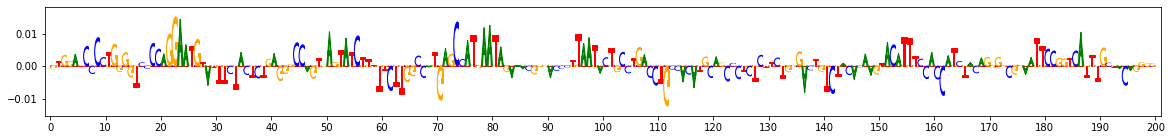

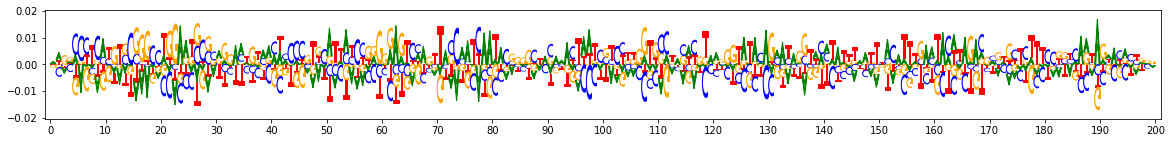

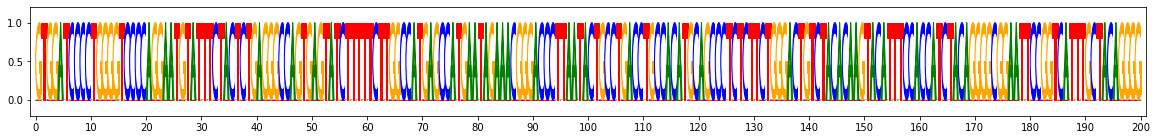

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

To demonstrate customization, the code below has the following modifications from the default settings:
- An empirical null distribution is supplied for per-position importance scores using the argument `null_per_pos_scores`
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, importance scores are first smoothed with a window of size `sliding_window_size` (default value of 21 at the time of writing), and the FDR for scores in sliding windows is estimated using the supplied empirical null distribution. This is used to set a threshold on sliding windows that can go on to form seqlets. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.
- (new in version 0.5.6.0) MEME is run on the seqlets to find 10 motifs, and the significant motifs are used to initialize TF-MoDISco's Leiden clustering. This initialization is handled by the initclusterer_factory argument.
- The `final_min_cluster_size` is set to 20 rather than the default of 30. The `final_min_cluster_size` determines the minimum support needed (in terms of number of seqlets) for a cluster to be displayed. It was lowered here to potentially enable better comparison to the MEME results, as the MEME motifs can sometimes have very few seqlets.

TF-MoDISco is using the TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term
MEMORY 0.344047616
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold


TF-MoDISco is using the TensorFlow backend.


For increasing = True , the minimum IR precision was 0.28762191141268867 occurring at 1.1961500000490233e-06 implying a frac_neg of 0.40374895862260485
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4829015187051677 occurring at -5.614999999965353e-07 implying a frac_neg of 0.9338676019623297
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.21752344639999993  and  0.15626441020500015 with frac passing 0.07338541666666666
Final raw thresholds are -0.21752344639999993  and  0.15626441020500015
Final transformed thresholds are -0.9723900462962963  and  0.9213773148148148


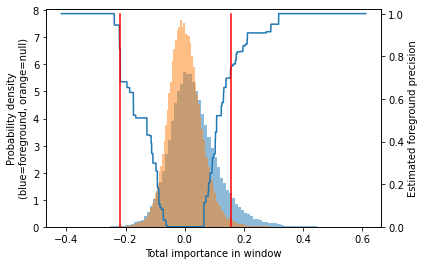

Got 923 coords
After resolving overlaps, got 923 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9212773148148148
MEMORY 0.42612736
923 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [903]
Idx to activities:  {0: '1'}
MEMORY 0.426139648
On metacluster 0
Metacluster size 903
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
Running MEME
Command: meme meme_out/metacluster0/inp_seqlets.fa -dna -mod zoops -nmotifs 10 -p 4 -minw 6 -maxw 50 -objfun classic -revcomp -markov_order 0 -oc meme_out/metacluster0
Duration of MEME: 439.7006449699402 seconds
Skipping motif AGCAGGSYYCWSAG as e-value 1.5 does not meet threshold of 0.05
Skipping motif RAKSCCTTTGAAR as e-value 200.0 does not meet threshold of 0.05
Skipping motif GAATAGAYKGTRAATGTTTCT as e-value 260000.0 does not meet threshold of 0.05
Skipping motif KGCCAGSMAKG as e-value 670000.0 does not meet threshold of 0.0

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 896 out of 903 | elapsed:   16.4s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 903 out of 903 | elapsed:   16.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 903 out of 903 | elapsed:   16.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 903 out of 903 | elapsed:    2.2s finished


Constructing csr matrix...
csr matrix made in 0.2086799144744873 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 903 out of 903 | elapsed:    2.2s finished


Constructing csr matrix...
csr matrix made in 0.20486116409301758 s
Finished embedding computation in 38.33 s
MEMORY 0.76439552
Starting affinity matrix computations
MEMORY 0.76439552
Batching in slices of size 903


100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

Finished affinity matrix computations in 2.01 s
MEMORY 0.78708736
(Round 1) Computed coarse affmat
MEMORY 0.78708736
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.78708736


Launching nearest neighbors affmat calculation job
MEMORY 0.791609344
Parallel runs completed
MEMORY 0.852348928
Job completed in: 17.61 s
MEMORY 0.852348928
Launching nearest neighbors affmat calculation job
MEMORY 0.852348928
Parallel runs completed
MEMORY 0.867811328
Job completed in: 18.97 s
MEMORY 0.867811328
(Round 1) Computed affinity matrix on nearest neighbors in 36.88 s
MEMORY 0.877600768
Filtered down to 893 of 903
(Round 1) Retained 893 rows out of 903 after filtering
MEMORY 0.877830144
(Round 1) Computing density adapted affmat
MEMORY 0.87853056
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 0.962039808
Beginning preprocessing + Leiden
initclusters length: 893
Affmat shape: 893


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.8s


Quality: 0.20379284241764992


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Affmat shape: 893


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.3s


Got 3 clusters after round 1
Counts:
{0: 527, 1: 357, 2: 9}
MEMORY 0.96233472
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.96233472
Aggregating for cluster 0 with 527 seqlets
MEMORY 0.96233472
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   12.1s finished


Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 8 seqlets that went over the sequence edge during flank expansion
Skipped 75 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 440
Skipped 42 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 357 seqlets
MEMORY 0.962998272
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 4 seqlets that went over the sequence edge during flank expansion
Skipped 39 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 312
Skipped 29 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 9 seqlets
MEMORY 0.963919872
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over sequence edge during flank 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 688 out of 688 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 616 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 688 out of 688 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 688 out of 688 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.14928507804870605 s


[Parallel(n_jobs=1)]: Done 688 out of 688 | elapsed:    1.7s finished


Constructing csr matrix...
csr matrix made in 0.152069091796875 s
Finished embedding computation in 21.59 s
MEMORY 0.97132544
Starting affinity matrix computations
MEMORY 0.97132544
Batching in slices of size 688


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

Finished affinity matrix computations in 1.86 s
MEMORY 0.973754368
(Round 2) Computed coarse affmat
MEMORY 0.973754368
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 0.973754368
Launching nearest neighbors affmat calculation job
MEMORY 0.976576512


Parallel runs completed
MEMORY 0.992026624
Job completed in: 21.04 s
MEMORY 0.992026624
Launching nearest neighbors affmat calculation job
MEMORY 0.992026624
Parallel runs completed
MEMORY 1.003200512
Job completed in: 22.13 s
MEMORY 1.003200512
(Round 2) Computed affinity matrix on nearest neighbors in 43.42 s
MEMORY 1.004478464
Not applying filtering for rounds above first round
MEMORY 1.004478464
(Round 2) Computing density adapted affmat
MEMORY 1.004478464
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 2) Computing clustering
MEMORY 1.02795264
Beginning preprocessing + Leiden
initclusters length: 688
Affmat shape: 688


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.8s


Quality: 0.10414790277112938


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Affmat shape: 688


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.9s


Got 4 clusters after round 2
Counts:
{0: 381, 1: 297, 2: 9, 3: 1}
MEMORY 1.02795264
(Round 2) Aggregating seqlets in each cluster
MEMORY 1.02795264
Aggregating for cluster 0 with 381 seqlets
MEMORY 1.02795264


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.2s finished


Skipped 2 seqlets that went over sequence edge during flank expansion
Skipped 4 due to duplicates
Trimming eliminated 0 seqlets out of 375
Skipped 38 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 297 seqlets
MEMORY 1.029976064
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 6 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 290
Skipped 32 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 9 seqlets
MEMORY 1.030144
Trimming eliminated 0 seqlets out of 9
Aggregating for cluster 3 with 1 seqlets
MEMORY 1.030144
Trimming eliminated 0 seqlets out of 1
Dropping cluster 3 with 1 seqlets due to sign disagreement
Got 3 clusters
Splitting into subclusters...
MEMORY 1.030144
Inspecting pattern 0 for spurious merging


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 252 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 330 out of 337 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 337 out of 337 | elapsed:    0.3s finished


[t-SNE] Computed conditional probabilities for sample 337 / 337
[t-SNE] Mean sigma: 0.367958
Beginning preprocessing + Leiden
Affmat shape: 337


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s


Quality: 0.3811643006789208
Got subclusters: Counter({0: 145, 1: 120, 2: 45, 3: 24, 4: 3})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.1s finished


Numbers for each pattern pre-subsample: [145, 120, 45, 24, 3]
Numbers after subsampling: [145, 120, 45, 24, 3]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.4862060546875 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.3203761577606201 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.15760302543640137 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.11910486221313477 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.05461883544921875 s
Cluster sizes
[145 120  45  24   3]
Cross-contamination matrix:
[[1.   0.51 0.71 0.4  0.36]
 [0.44 1.   0.55 0.27 0.37]
 [0.61 0.54 1.   0.37 0.3 ]
 [0.8  0.65 0.87 1.   0.48]
 [0.01 0.01 0.01 0.   1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.58 0.76 0.72 0.51]
 [0.58 1.   0.65 0.56 0.43]
 [0.76 0.65 1.   0.73 0.46]
 [0.72 0.56 0.73 1.   0.44]
 [0.51 0.43 0.46 0.44 1.  ]]
Inspecting pattern 1 for spurious merging


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 220 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 258 out of 258 | elapsed:    0.1s finished


[t-SNE] Computed conditional probabilities for sample 258 / 258
[t-SNE] Mean sigma: 0.333458
Beginning preprocessing + Leiden
Affmat shape: 258


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s


Quality: 0.205450908849162
Quality: 0.20907819497599844
Quality: 0.209502970012075
Quality: 0.2099976713804717
Quality: 0.2101135664643977
Got subclusters: Counter({0: 52, 1: 51, 2: 46, 3: 43, 4: 28, 5: 18, 6: 17, 7: 3})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.7s finished


Numbers for each pattern pre-subsample: [52, 51, 46, 43, 28, 18, 17, 3]
Numbers after subsampling: [52, 51, 46, 43, 28, 18, 17, 3]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.3022439479827881 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.26720619201660156 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.23551225662231445 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.21485328674316406 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.1712932586669922 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.13495874404907227 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.11603307723999023 s
Computing sims for pattern 7
Computed sims for pattern 7 in 0.062103986740112305 s
Cluster sizes
[52 51 46 43 28 18 17  3]
Cross-contamination matrix:
[[1.   1.   0.81 1.   0.97 0.8  0.72 0.89]
 [0.42 1.   0.41 0.82 0.58 0.33 0.28 0.28]
 [0.82 1.   1.   1.   0.92 0.85 0.79 0.87]
 [0.4  0.89 0.38 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:    0.1s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


[t-SNE] Iteration 50: error = 64.1727219, gradient norm = 0.4908918 (50 iterations in 0.048s)
[t-SNE] Iteration 100: error = 66.6016922, gradient norm = 0.4365885 (50 iterations in 0.043s)
[t-SNE] Iteration 150: error = 66.5666656, gradient norm = 0.4884390 (50 iterations in 0.041s)
[t-SNE] Iteration 200: error = 67.7021637, gradient norm = 0.4277766 (50 iterations in 0.039s)
[t-SNE] Iteration 250: error = 66.3721161, gradient norm = 0.4645458 (50 iterations in 0.047s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.372116
[t-SNE] Iteration 300: error = 1.1076591, gradient norm = 0.0062155 (50 iterations in 0.039s)
[t-SNE] Iteration 350: error = 0.7743291, gradient norm = 0.0022317 (50 iterations in 0.042s)
[t-SNE] Iteration 400: error = 0.7670449, gradient norm = 0.0007970 (50 iterations in 0.039s)
[t-SNE] Iteration 450: error = 0.7675513, gradient norm = 0.0000938 (50 iterations in 0.036s)
[t-SNE] Iteration 500: error = 0.7675611, gradient norm = 0.0000744 (50 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s


Quality: 0.19227679234713466
Quality: 0.19290088730945618
Quality: 0.19393889822704266
Quality: 0.1940674892277672
Quality: 0.19431442345375388


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:    0.1s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 47, 1: 43, 2: 38, 3: 37, 4: 35, 5: 7, 6: 5, 7: 4})
On pattern 1
[t-SNE] Computing 144 nearest neighbors...
[t-SNE] Indexed 145 samples in 0.002s...
[t-SNE] Computed neighbors for 145 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 145 / 145
[t-SNE] Mean sigma: 0.387829
[t-SNE] Computed conditional probabilities in 0.007s
[t-SNE] Iteration 50: error = 63.5247879, gradient norm = 0.4872783 (50 iterations in 0.025s)
[t-SNE] Iteration 100: error = 62.3236237, gradient norm = 0.4612131 (50 iterations in 0.024s)
[t-SNE] Iteration 150: error = 61.9164543, gradient norm = 0.5189757 (50 iterations in 0.022s)
[t-SNE] Iteration 200: error = 58.2172546, gradient norm = 0.4829160 (50 iterations in 0.035s)
[t-SNE] Iteration 250: error = 61.6381493, gradient norm = 0.4954515 (50 iterations in 0.028s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.638149
[t-SNE] Iteration 300: error = 1.0649891, gradient norm = 0.0071776 (

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s


Quality: 0.19638365678499384
Quality: 0.19783949523952613
Quality: 0.19894375391633962
Quality: 0.19910197494264673


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 42, 1: 34, 2: 28, 3: 23, 4: 18})
On pattern 2
[t-SNE] Computing 119 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.001s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 0.433798
[t-SNE] Computed conditional probabilities in 0.005s
[t-SNE] Iteration 50: error = 64.9264832, gradient norm = 0.4025871 (50 iterations in 0.023s)
[t-SNE] Iteration 100: error = 62.2776184, gradient norm = 0.4540638 (50 iterations in 0.021s)
[t-SNE] Iteration 150: error = 61.5584793, gradient norm = 0.4598874 (50 iterations in 0.019s)
[t-SNE] Iteration 200: error = 59.5484924, gradient norm = 0.4670514 (50 iterations in 0.019s)
[t-SNE] Iteration 250: error = 65.2899933, gradient norm = 0.4294555 (50 iterations in 0.022s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.289993
[t-SNE] Iteration 300: error = 0.9629128, gradient norm = 0.0066913 (50 iterations in 0

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s


Quality: 0.20429581026274202
Quality: 0.20453626725698923
Quality: 0.20516343712827284


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 42, 2: 38, 1: 38, 3: 2})
On pattern 3
[t-SNE] Computing 44 nearest neighbors...
[t-SNE] Indexed 45 samples in 0.001s...
[t-SNE] Computed neighbors for 45 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 45 / 45
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.003s
[t-SNE] Iteration 50: error = 49.4132080, gradient norm = 0.3649440 (50 iterations in 0.018s)
[t-SNE] Iteration 100: error = 43.2783356, gradient norm = 0.4182964 (50 iterations in 0.015s)
[t-SNE] Iteration 150: error = 48.2020035, gradient norm = 0.6657472 (50 iterations in 0.012s)
[t-SNE] Iteration 200: error = 42.3871727, gradient norm = 0.5487152 (50 iterations in 0.011s)
[t-SNE] Iteration 250: error = 45.2206650, gradient norm = 0.5526590 (50 iterations in 0.012s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.220665
[t-SNE] Iteration 300: error = 0.7855160, gradient norm = 0.0010573 (50 iterations in

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s


Quality: -1.6509016376176883e-13


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 45})
On pattern 4
[t-SNE] Computing 23 nearest neighbors...
[t-SNE] Indexed 24 samples in 0.001s...
[t-SNE] Computed neighbors for 24 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 24 / 24
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 49.2344131, gradient norm = 0.5288350 (50 iterations in 0.010s)
[t-SNE] Iteration 100: error = 50.6861191, gradient norm = 0.5744531 (50 iterations in 0.013s)
[t-SNE] Iteration 150: error = 45.8535538, gradient norm = 0.6550605 (50 iterations in 0.012s)
[t-SNE] Iteration 200: error = 44.3336411, gradient norm = 0.3698129 (50 iterations in 0.010s)
[t-SNE] Iteration 250: error = 48.0599976, gradient norm = 0.5015129 (50 iterations in 0.013s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.059998
[t-SNE] Iteration 300: error = 0.4756823, gradient norm = 0.0007955 (50 iterations in 0.014s)
[t-SNE] Ite

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s


Quality: 6.03961325396083e-14
Got subclusters: Counter({0: 24})


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.9s finished


In [4]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        meme_command="meme", base_outdir="meme_out",   
                        #max_num_seqlets_to_use specifies the maximum number of seqlets to use
                        # with MEME (this is to speed up MEME in the cases where the number of seqlets is
                        #  very large)
                        max_num_seqlets_to_use=10000,
                        nmotifs=10,
                        n_jobs=4),
                    use_louvain=False,
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    #trim_to_window_size=6,
                    #initial_flank_to_add=2,
                    #final_flank_to_add=5,
                    final_min_cluster_size=20
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [5]:
import h5py
import modisco.util
reload(modisco.util)
! [[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


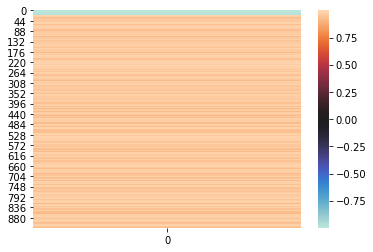

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 216
Hypothetical scores:


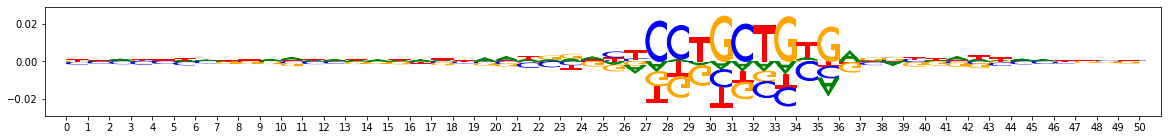

Actual importance scores:


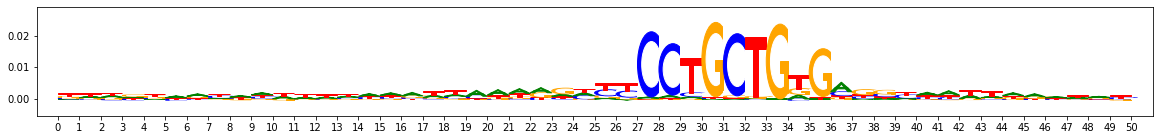

onehot, fwd and rev:


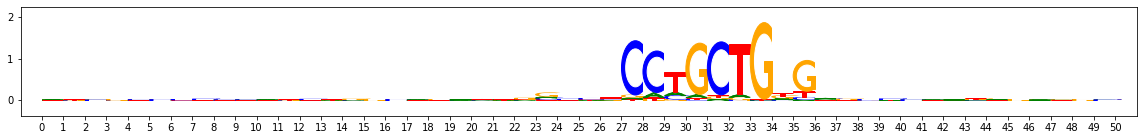

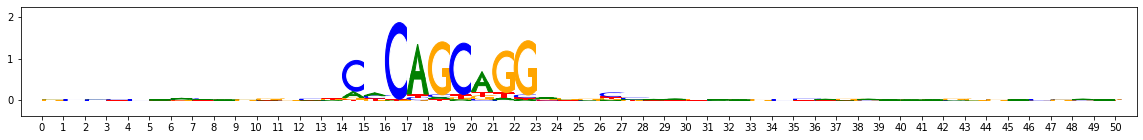

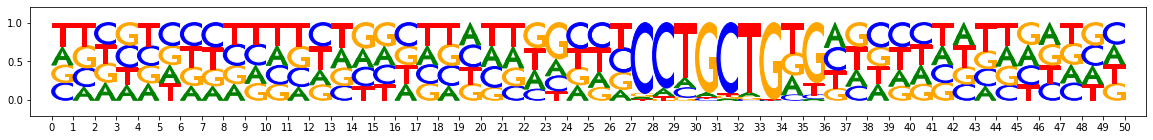

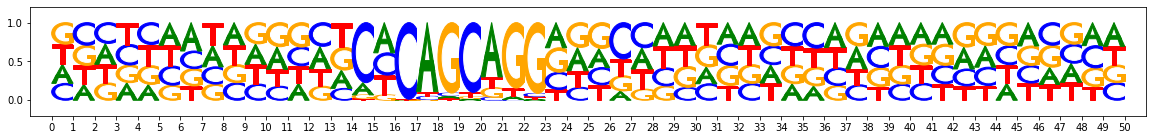

metacluster_0 pattern_1
total seqlets: 145
Hypothetical scores:


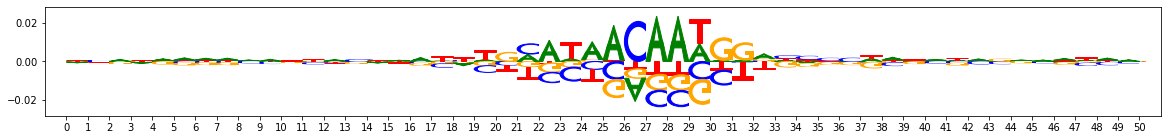

Actual importance scores:


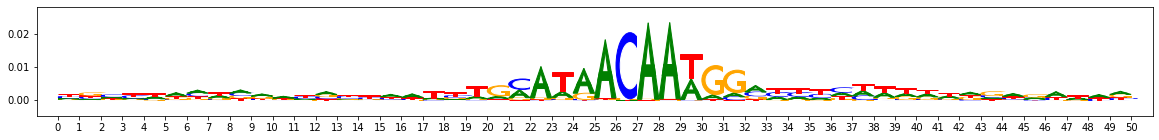

onehot, fwd and rev:


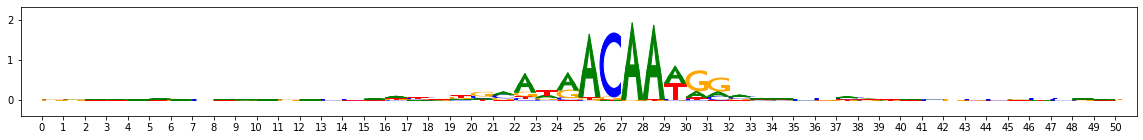

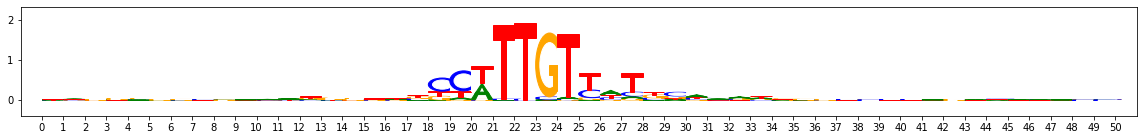

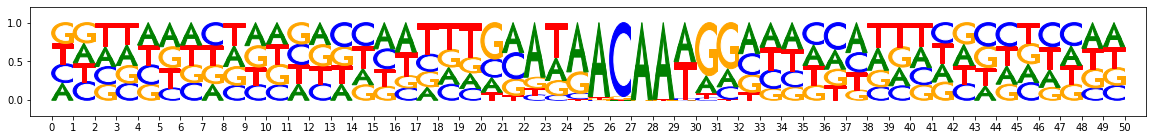

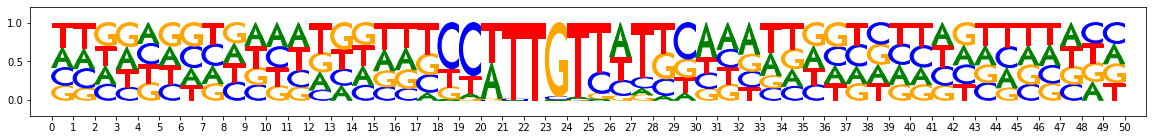

metacluster_0 pattern_2
total seqlets: 120
Hypothetical scores:


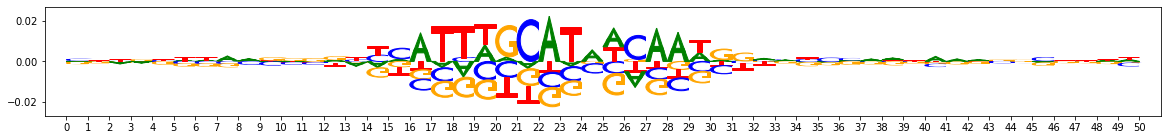

Actual importance scores:


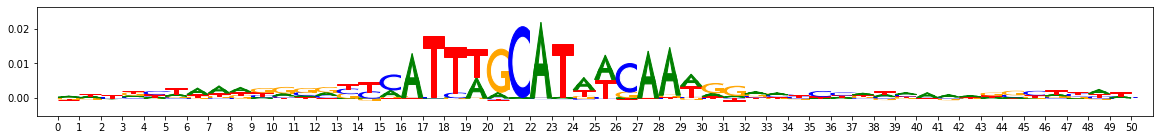

onehot, fwd and rev:


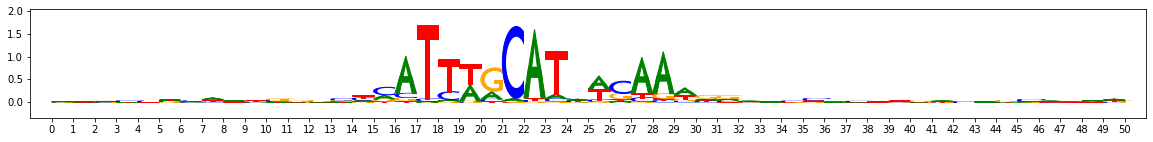

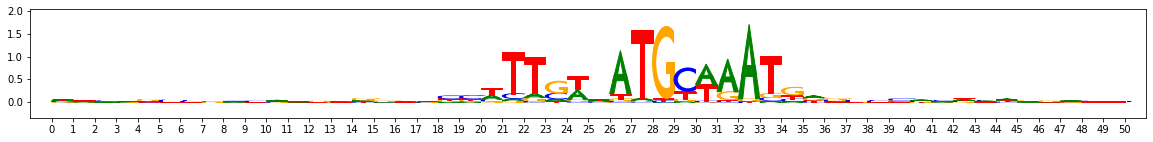

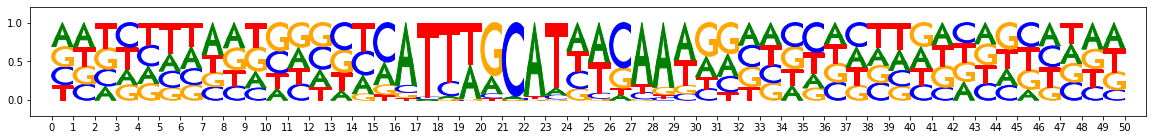

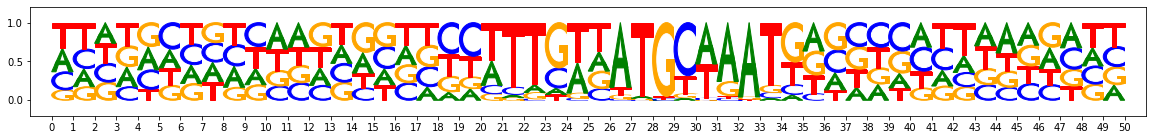

metacluster_0 pattern_3
total seqlets: 45
Hypothetical scores:


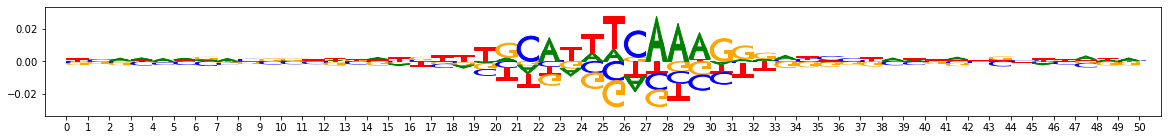

Actual importance scores:


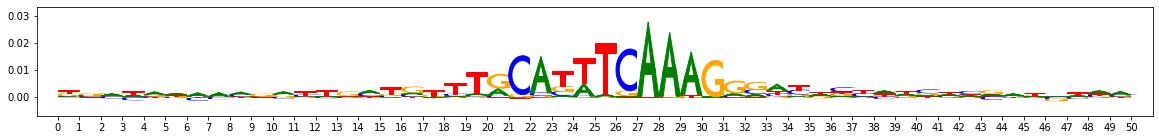

onehot, fwd and rev:


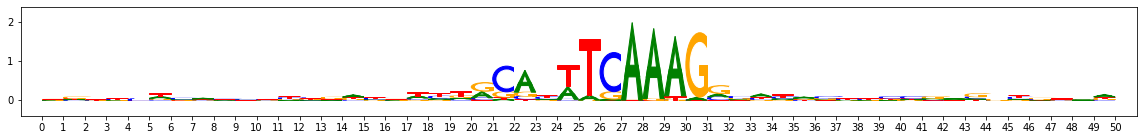

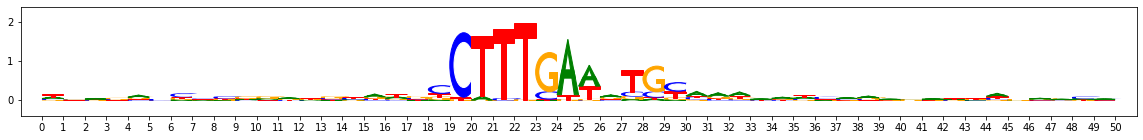

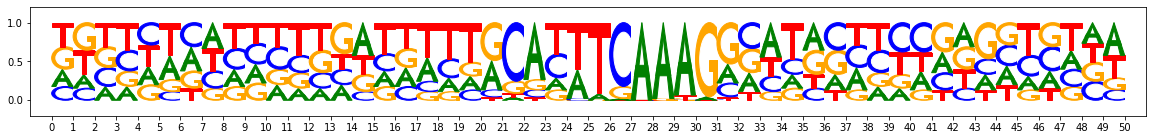

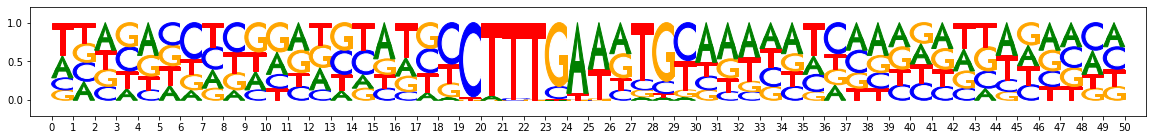

metacluster_0 pattern_4
total seqlets: 24
Hypothetical scores:


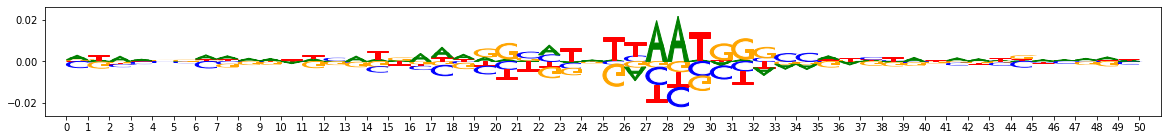

Actual importance scores:


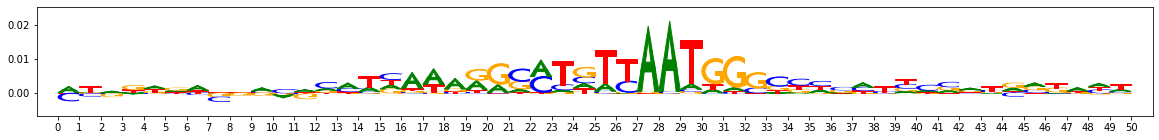

onehot, fwd and rev:


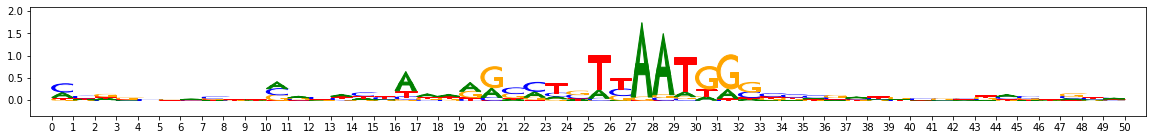

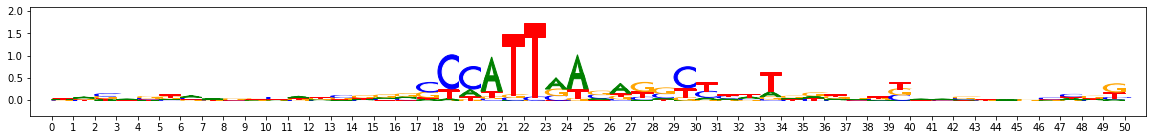

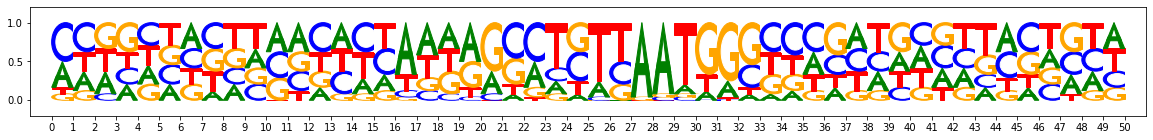

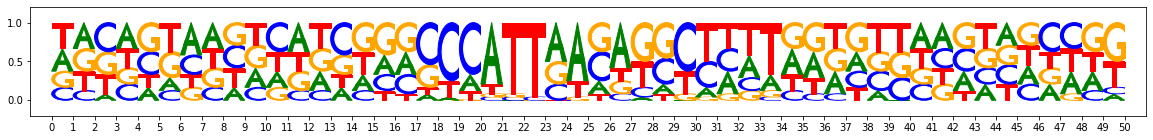

In [6]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background))
        viz_sequence.plot_weights(pattern["sequence"]["fwd"]) 
        viz_sequence.plot_weights(pattern["sequence"]["rev"]) 
        
hdf5_results.close()

### (extra) Visualize the result of using MEME's motifs to initialize the seqlets
This visualizes the intermediate stage where the MEME-derived motifs are used to create an initial set of seqlet clusters. Can be used to get insight into how the MEME-based initialization influenced the TF-MoDISco results

Inspecting meme-based initialization for seqlets in round 1
round 1 MEME-DISco motif number 0
num seqlets mapped to this motif: 205


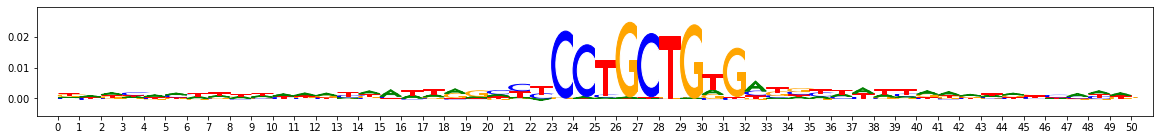

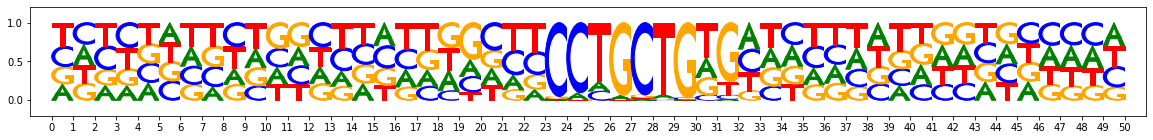

round 1 MEME-DISco motif number 1
num seqlets mapped to this motif: 183


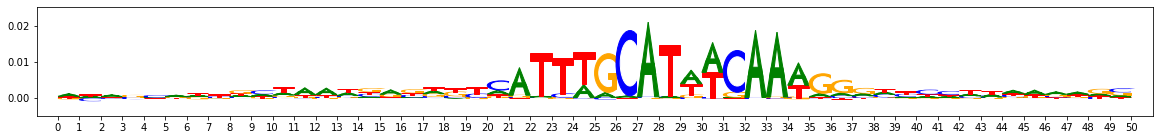

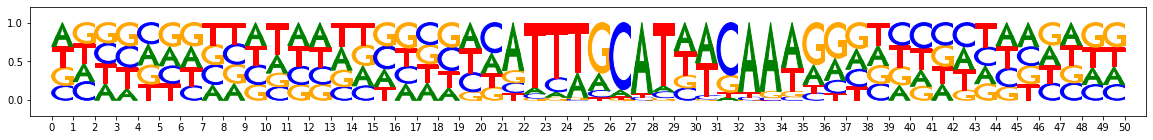

round 1 MEME-DISco motif number 2
num seqlets mapped to this motif: 132


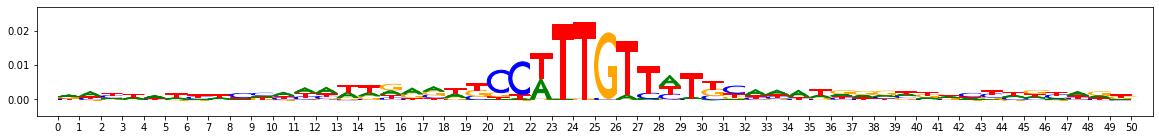

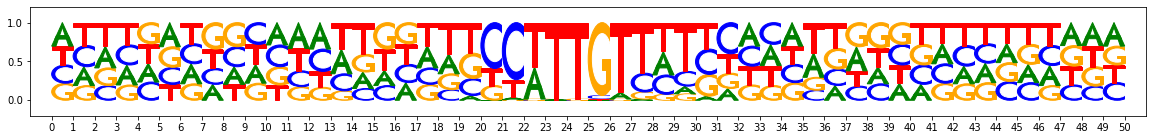

round 1 MEME-DISco motif number 3
num seqlets mapped to this motif: 58


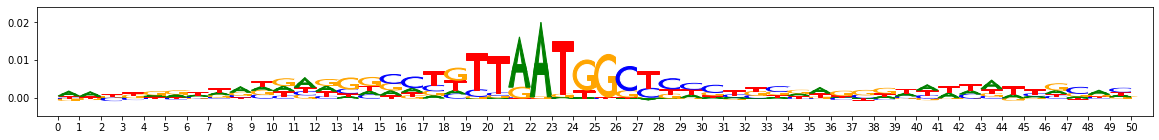

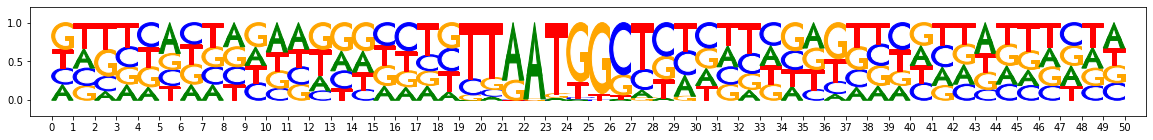

round 1 MEME-DISco motif number 4
num seqlets mapped to this motif: 32


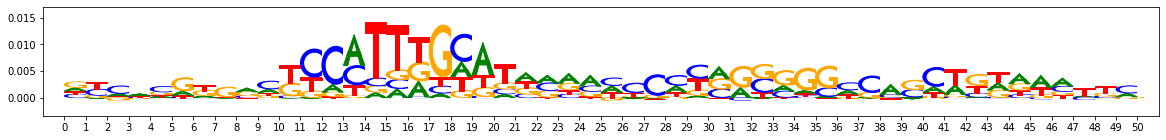

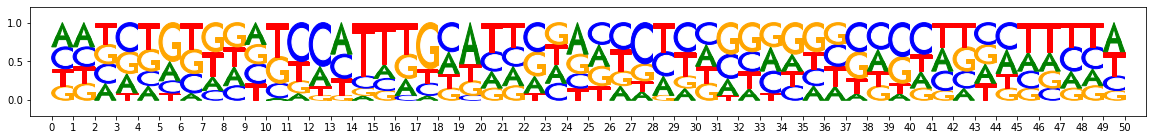

round 1 MEME-DISco motif number 5
num seqlets mapped to this motif: 11


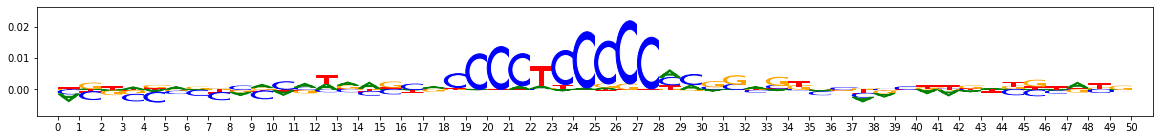

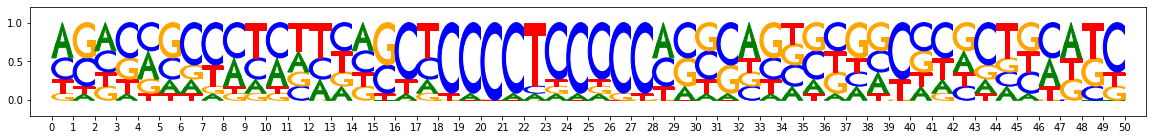

In [7]:
from modisco.visualization import viz_sequence
for round_idx in [1]:
    print("Inspecting meme-based initialization for seqlets in round",round_idx)
    meme_discovered_motifs = (tfmodisco_results
        .metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result
        .each_round_initcluster_motifs[round_idx])
    for idx,motif in enumerate(meme_discovered_motifs):
        print("round",round_idx,"MEME-DISco motif number",idx)
        print("num seqlets mapped to this motif:",len(motif.seqlets))
        viz_sequence.plot_weights(motif["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(motif["sequence"].fwd)